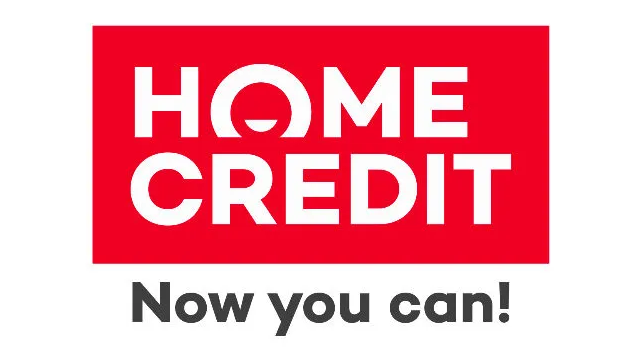

# Home Credit Default Risk - Kaggle Competition

"Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful. "

I have decided to participate to home credit kaggle competition and see if I will be able to accurately predict who can get a loan and who better not to! You can find competition page at https://www.kaggle.com/c/home-credit-default-risk/overview

One of the goals I am giving for myself is to get at least median private leaderboard score which is now **0.78592** 

## Data Schema

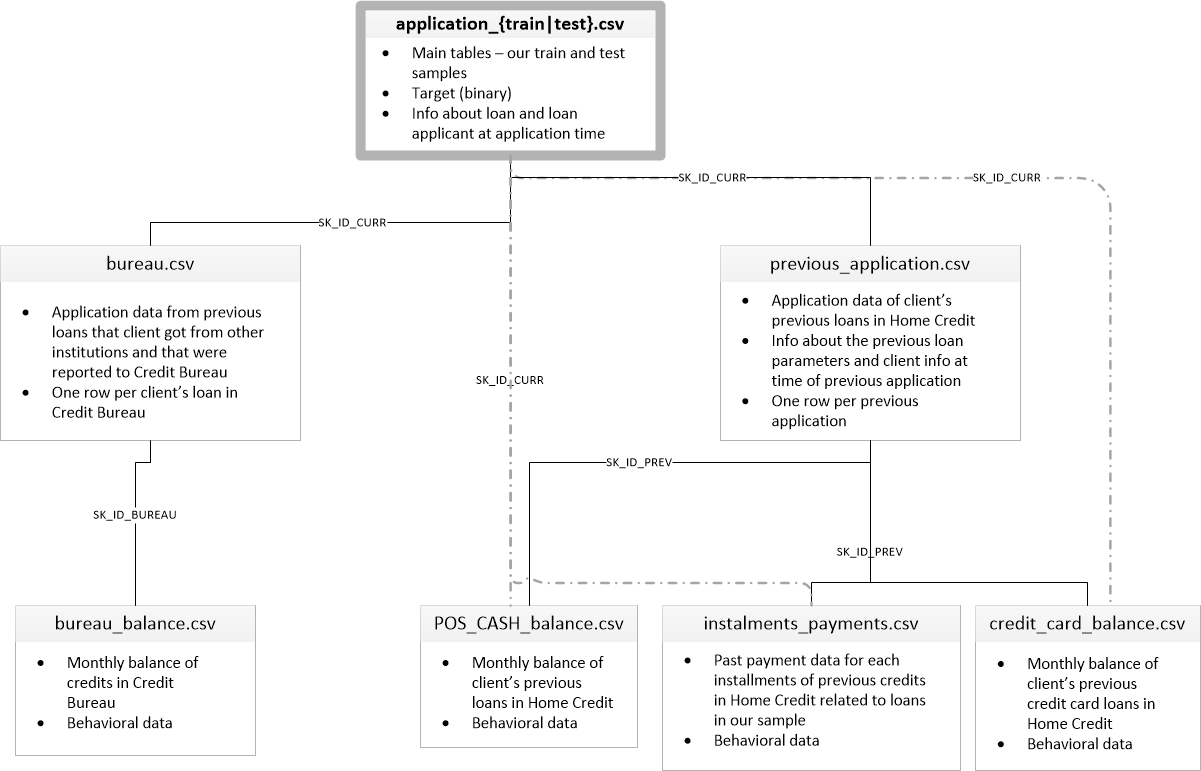

## Import Libraries

In [11]:
%load_ext nb_black
import homecredit_functions as hc
import imp

imp.reload(hc)
import pandas as pd

pd.set_option("display.float_format", lambda x: "%.5f" % x)
from tqdm import tqdm
import numpy as np
import re
from scipy import stats
import seaborn as sns

sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

RANDOM_STATE = 0

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# EDA

### Description dataset

For better understanding of columns abbreviations I have been using columns description dataset.

In [6]:
path_columns_description = "Data/HomeCredit_columns_description.csv"
df_columns_description = pd.read_csv(path_columns_description, encoding="ISO-8859-1")

<IPython.core.display.Javascript object>

In [20]:
list(df_columns_description[df_columns_description["Row"] == "TARGET"]["Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

<IPython.core.display.Javascript object>

### Application Test

In [12]:
path_application_test = "Data/application_test.csv"
df_application_test = pd.read_csv(path_application_test)

<IPython.core.display.Javascript object>

In [13]:
df_application_test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.00000,568800.00000,20560.50000,450000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,100005,Cash loans,M,N,Y,0,99000.00000,222768.00000,17370.00000,180000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000
2,100013,Cash loans,M,Y,Y,0,202500.00000,663264.00000,69777.00000,630000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,1.00000,4.00000
3,100028,Cash loans,F,N,Y,2,315000.00000,1575000.00000,49018.50000,1575000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000
4,100038,Cash loans,M,Y,N,1,180000.00000,625500.00000,32067.00000,625500.00000,...,0,0,0,0,nan,nan,nan,nan,nan,nan


<IPython.core.display.Javascript object>

In [19]:
df_application_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


<IPython.core.display.Javascript object>

In [6]:
df_application_test.shape

(48744, 121)

<IPython.core.display.Javascript object>

In [7]:
df_application_test.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df_application_test.select_dtypes(["int64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,48744.00000,277796.67635,103169.54730,100001.00000,188557.75000,277549.00000,367555.50000,456250.00000
CNT_CHILDREN,48744.00000,0.39705,0.70905,0.00000,0.00000,0.00000,1.00000,20.00000
DAYS_BIRTH,48744.00000,-16068.08461,4325.90039,-25195.00000,-19637.00000,-15785.00000,-12496.00000,-7338.00000
DAYS_EMPLOYED,48744.00000,67485.36632,144348.50714,-17463.00000,-2910.00000,-1293.00000,-296.00000,365243.00000
DAYS_ID_PUBLISH,48744.00000,-3051.71295,1569.27671,-6348.00000,-4448.00000,-3234.00000,-1706.00000,0.00000
FLAG_MOBIL,48744.00000,0.99998,0.00453,0.00000,1.00000,1.00000,1.00000,1.00000
FLAG_EMP_PHONE,48744.00000,0.80972,0.39253,0.00000,1.00000,1.00000,1.00000,1.00000
FLAG_WORK_PHONE,48744.00000,0.20470,0.40349,0.00000,0.00000,0.00000,0.00000,1.00000
FLAG_CONT_MOBILE,48744.00000,0.99840,0.03997,0.00000,1.00000,1.00000,1.00000,1.00000
FLAG_PHONE,48744.00000,0.26313,0.44034,0.00000,0.00000,0.00000,1.00000,1.00000


<IPython.core.display.Javascript object>

In [9]:
df_application_test.select_dtypes(["float64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,48744.00000,178431.80585,101522.59154,26941.50000,112500.00000,157500.00000,225000.00000,4410000.00000
AMT_CREDIT,48744.00000,516740.43556,365397.00417,45000.00000,260640.00000,450000.00000,675000.00000,2245500.00000
AMT_ANNUITY,48720.00000,29426.24021,16016.36832,2295.00000,17973.00000,26199.00000,37390.50000,180576.00000
AMT_GOODS_PRICE,48744.00000,462618.84047,336710.21504,45000.00000,225000.00000,396000.00000,630000.00000,2245500.00000
REGION_POPULATION_RELATIVE,48744.00000,0.02123,0.01443,0.00025,0.01001,0.01885,0.02866,0.07251
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,42695.00000,0.00180,0.04613,0.00000,0.00000,0.00000,0.00000,2.00000
AMT_REQ_CREDIT_BUREAU_WEEK,42695.00000,0.00279,0.05404,0.00000,0.00000,0.00000,0.00000,2.00000
AMT_REQ_CREDIT_BUREAU_MON,42695.00000,0.00930,0.11092,0.00000,0.00000,0.00000,0.00000,6.00000
AMT_REQ_CREDIT_BUREAU_QRT,42695.00000,0.54690,0.69331,0.00000,0.00000,0.00000,1.00000,7.00000


<IPython.core.display.Javascript object>

In [10]:
df_application_test.select_dtypes(["object"]).describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,48744,2,Cash loans,48305
CODE_GENDER,48744,2,F,32678
FLAG_OWN_CAR,48744,2,N,32311
FLAG_OWN_REALTY,48744,2,Y,33658
NAME_TYPE_SUITE,47833,7,Unaccompanied,39727
NAME_INCOME_TYPE,48744,7,Working,24533
NAME_EDUCATION_TYPE,48744,5,Secondary / secondary special,33988
NAME_FAMILY_STATUS,48744,5,Married,32283
NAME_HOUSING_TYPE,48744,6,House / apartment,43645
OCCUPATION_TYPE,33139,18,Laborers,8655


<IPython.core.display.Javascript object>

### Application Train

In [9]:
path_application_train = "Data/application_train.csv"
df_application_train = pd.read_csv(path_application_train)

<IPython.core.display.Javascript object>

In [12]:
df_application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,...,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


<IPython.core.display.Javascript object>

In [13]:
df_application_train.shape

(307511, 122)

<IPython.core.display.Javascript object>

In [14]:
df_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

<IPython.core.display.Javascript object>

In [15]:
df_application_train.select_dtypes(["int64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.00000,278180.51858,102790.17535,100002.00000,189145.50000,278202.00000,367142.50000,456255.00000
TARGET,307511.00000,0.08073,0.27242,0.00000,0.00000,0.00000,0.00000,1.00000
CNT_CHILDREN,307511.00000,0.41705,0.72212,0.00000,0.00000,0.00000,1.00000,19.00000
DAYS_BIRTH,307511.00000,-16036.99507,4363.98863,-25229.00000,-19682.00000,-15750.00000,-12413.00000,-7489.00000
DAYS_EMPLOYED,307511.00000,63815.04590,141275.76652,-17912.00000,-2760.00000,-1213.00000,-289.00000,365243.00000
DAYS_ID_PUBLISH,307511.00000,-2994.20237,1509.45042,-7197.00000,-4299.00000,-3254.00000,-1720.00000,0.00000
FLAG_MOBIL,307511.00000,1.00000,0.00180,0.00000,1.00000,1.00000,1.00000,1.00000
FLAG_EMP_PHONE,307511.00000,0.81989,0.38428,0.00000,1.00000,1.00000,1.00000,1.00000
FLAG_WORK_PHONE,307511.00000,0.19937,0.39953,0.00000,0.00000,0.00000,0.00000,1.00000
FLAG_CONT_MOBILE,307511.00000,0.99813,0.04316,0.00000,1.00000,1.00000,1.00000,1.00000


<IPython.core.display.Javascript object>

In [16]:
df_application_train.select_dtypes(["float64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307511.00000,168797.91930,237123.14628,25650.00000,112500.00000,147150.00000,202500.00000,117000000.00000
AMT_CREDIT,307511.00000,599025.99971,402490.77700,45000.00000,270000.00000,513531.00000,808650.00000,4050000.00000
AMT_ANNUITY,307499.00000,27108.57391,14493.73732,1615.50000,16524.00000,24903.00000,34596.00000,258025.50000
AMT_GOODS_PRICE,307233.00000,538396.20743,369446.46054,40500.00000,238500.00000,450000.00000,679500.00000,4050000.00000
REGION_POPULATION_RELATIVE,307511.00000,0.02087,0.01383,0.00029,0.01001,0.01885,0.02866,0.07251
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.00000,0.00700,0.11076,0.00000,0.00000,0.00000,0.00000,9.00000
AMT_REQ_CREDIT_BUREAU_WEEK,265992.00000,0.03436,0.20468,0.00000,0.00000,0.00000,0.00000,8.00000
AMT_REQ_CREDIT_BUREAU_MON,265992.00000,0.26740,0.91600,0.00000,0.00000,0.00000,0.00000,27.00000
AMT_REQ_CREDIT_BUREAU_QRT,265992.00000,0.26547,0.79406,0.00000,0.00000,0.00000,0.00000,261.00000


<IPython.core.display.Javascript object>

In [17]:
df_application_train.select_dtypes(["object"]).describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


<IPython.core.display.Javascript object>

**Observation**:
* Datasets are mixed with numerical and categorical features
* By first glance train and test distributions roughly looks the same
* Iterestingly someone has 19 childrens when mean is only 0.41705.
* AMT_INCOME_TOTAL has very high maximum value.

c:\users\gelezis\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Target distribution')]

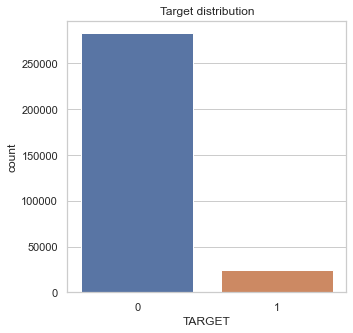

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(df_application_train["TARGET"])
ax.set(
    title="Target distribution",
)

**Observation**:
* Target is highly imbalanced.

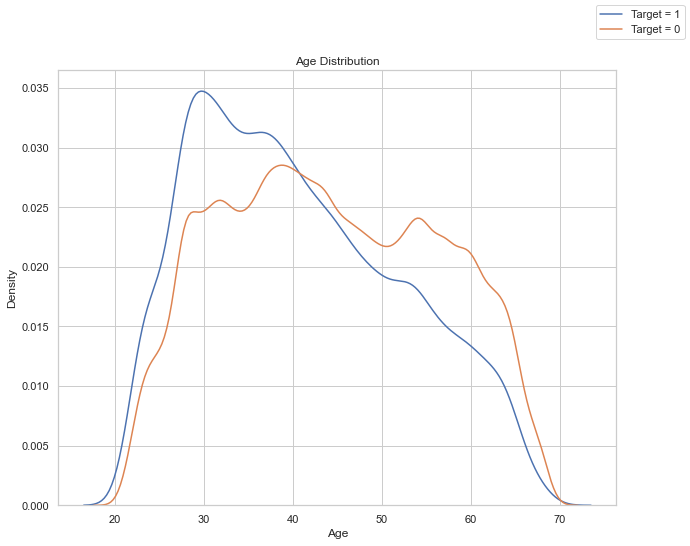

<IPython.core.display.Javascript object>

In [19]:
fig = plt.figure(figsize=(10, 8))
plt.title("Age Distribution")
plt.xlabel("Age")
sns.kdeplot(
    df_application_train[df_application_train["TARGET"] == 1]["DAYS_BIRTH"] / -365,
)
sns.kdeplot(
    df_application_train[df_application_train["TARGET"] == 0]["DAYS_BIRTH"] / -365
)
fig.legend(labels=["Target = 1", "Target = 0"])
plt.show()

**Observation**:
* Most of the people who have difficulty to repay their loan (target=1) at the age of 30 and most of the people can repay when they are around 39 years old.

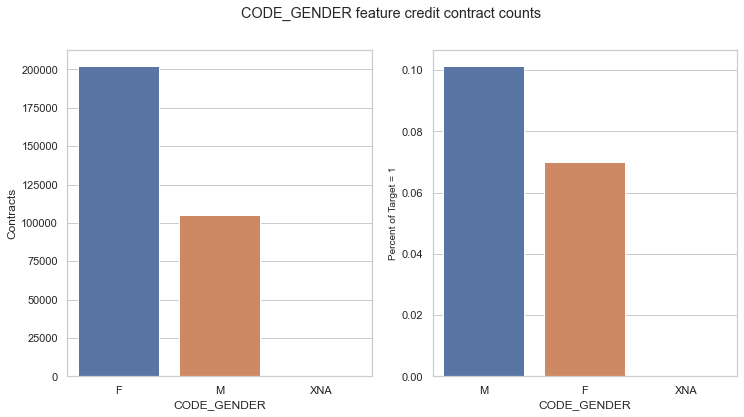

<IPython.core.display.Javascript object>

In [20]:
hc.plot_count(df_application_train, "CODE_GENDER")

**Observation**:
* Females took almost twice as much contracts than males. Although males have bigger percentage of not repaying their credit.

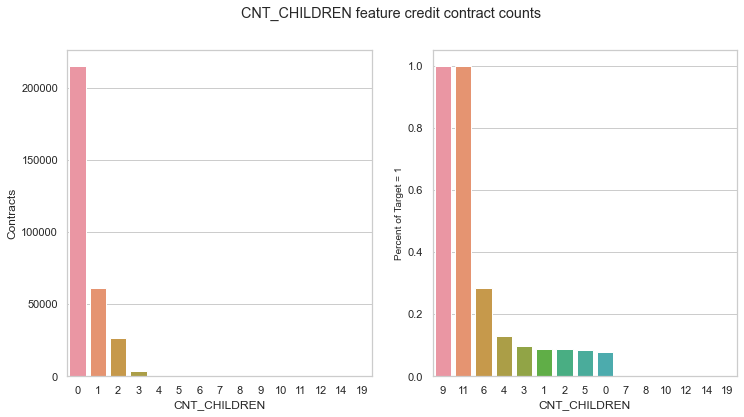

<IPython.core.display.Javascript object>

In [21]:
hc.plot_count(df_application_train, "CNT_CHILDREN")

**Observation**:
* Most of people who didn't have children took credits. The clients with 4 and 6 children are above average in terms of percent of not paid back credits (over 25% for families with 6 children).

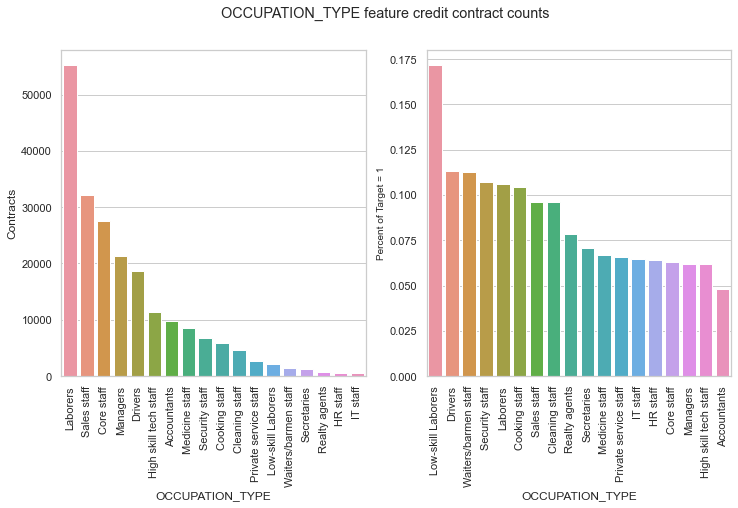

<IPython.core.display.Javascript object>

In [22]:
hc.plot_count(df_application_train, "OCCUPATION_TYPE", True)

**Observation**:
* Significant portion of credits are taken by laborers  and least by IT staff. Low-skill laborers has biggest percentage of not paying back their loans.

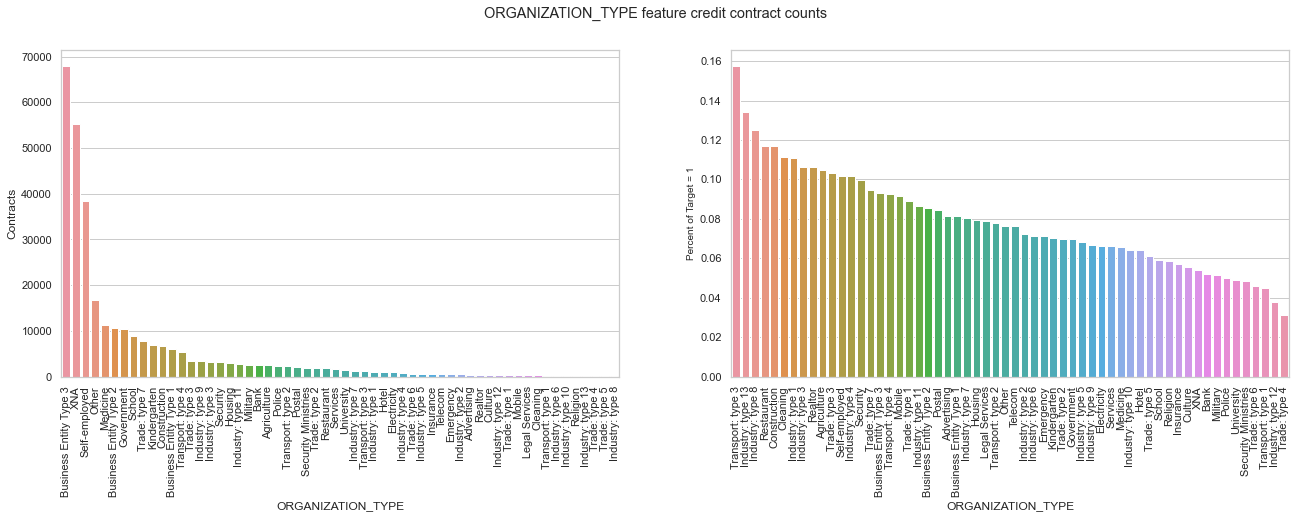

<IPython.core.display.Javascript object>

In [23]:
hc.plot_count(df_application_train, "ORGANIZATION_TYPE", True, (22, 6))

**Observation**:
* Organizations with highest percent of loans not repaid are Transport: type 3 (about 16%), Industry: type 13 (about 13.5%). Business entetity type 3 is number one in taking home credits

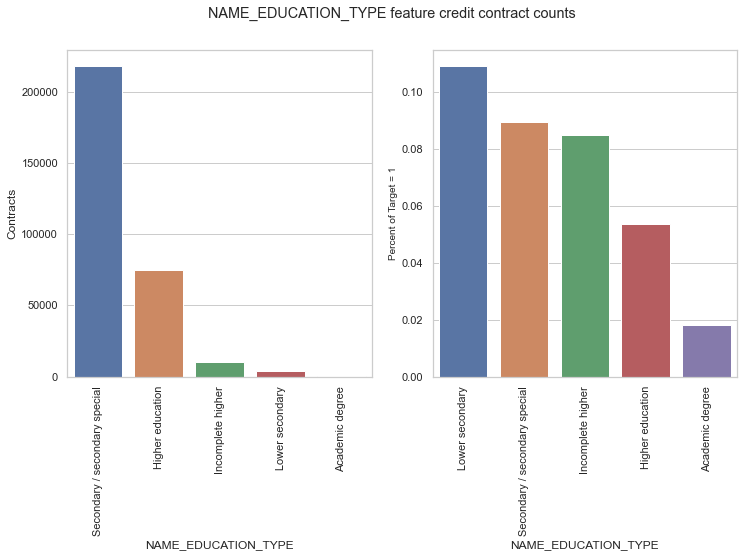

<IPython.core.display.Javascript object>

In [24]:
hc.plot_count(df_application_train, "NAME_EDUCATION_TYPE", True)

**Observation**:
* People with Secondary/secondary special education has majority of credit taken, although lower secondary has biggest percentage of not paying credits. We can see trend that the higher education people have the more chance that they will pay loan on time.

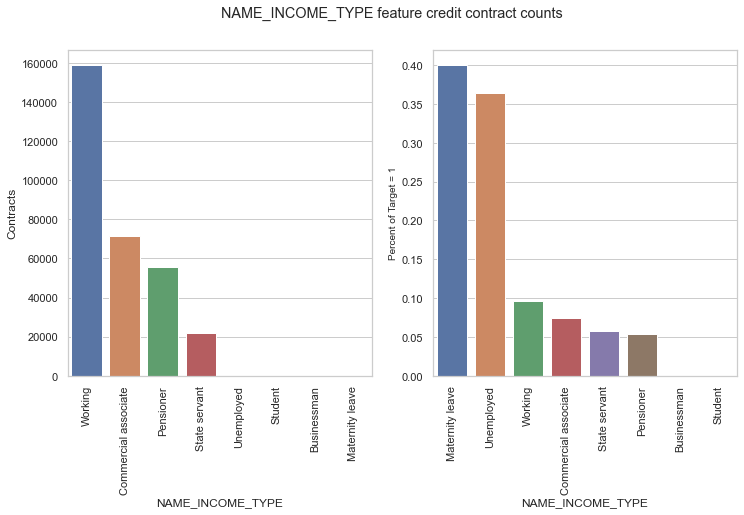

<IPython.core.display.Javascript object>

In [25]:
hc.plot_count(df_application_train, "NAME_INCOME_TYPE", True)

**Observation**:
* Almost a half of credits are taken by working people although they are just in third place of not giving back their loans. Highest percentage of not paying their credits have maternity leave and unemployed people.

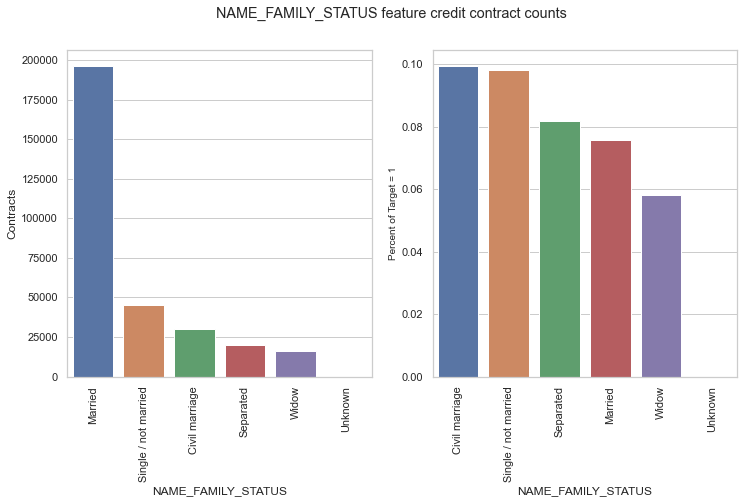

<IPython.core.display.Javascript object>

In [26]:
hc.plot_count(df_application_train, "NAME_FAMILY_STATUS", True)

**Observation**:
* Married people has most credits taken. In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment 

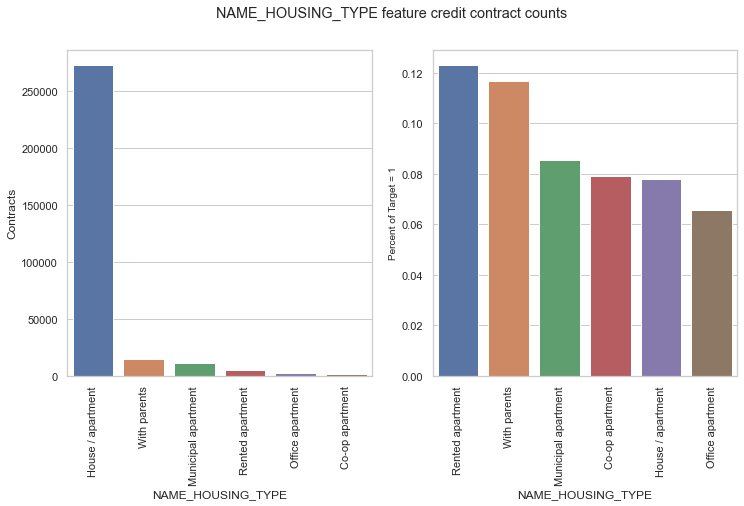

<IPython.core.display.Javascript object>

In [27]:
hc.plot_count(df_application_train, "NAME_HOUSING_TYPE", True)

**Observation**:
* Almost every credit taker has house or apartments, although people who has rented apartment or living with their parents has biggest chance of not paying their credits.

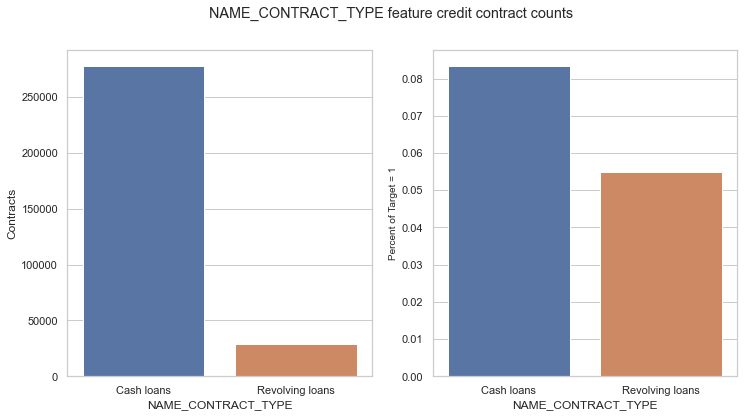

<IPython.core.display.Javascript object>

In [28]:
hc.plot_count(df_application_train, "NAME_CONTRACT_TYPE")

**Observation**:
* Most loans are cash loans and they have slightly bigger percentage of no repayment.

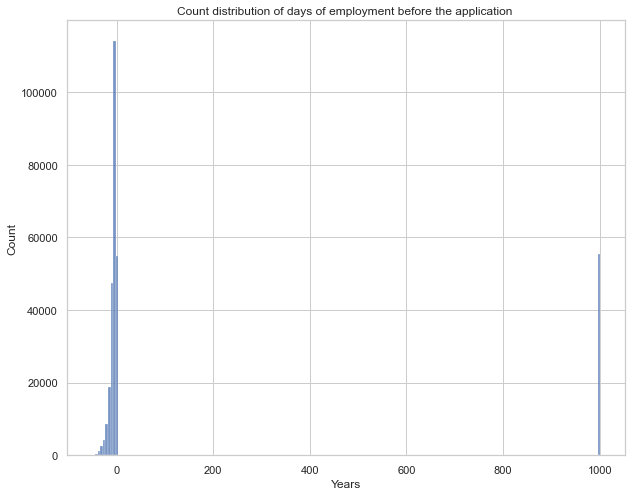

<IPython.core.display.Javascript object>

In [29]:
fig = plt.figure(figsize=(10, 8))
plt.title("Count distribution of days of employment before the application ")
plt.xlabel("Years")
sns.histplot(df_application_train["DAYS_EMPLOYED"] / 365, bins=200)
plt.show()

**Observation**:
* Weirdly days since employed before application has negative values which perhaps mean unemploymed. Moreover It is not clear what will be the meaning of the very large numbers where people are employed more than 900 years, although most likely these samples will need to be clipped or removed.

# Data Wrangling

## Missing Values

In [30]:
application_missing_values_train = hc.missing_values(df_application_train)
application_missing_values_train.head(5)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.90000
COMMONAREA_AVG,214865,69.90000
COMMONAREA_MODE,214865,69.90000
NONLIVINGAPARTMENTS_MEDI,213514,69.40000
NONLIVINGAPARTMENTS_MODE,213514,69.40000


<IPython.core.display.Javascript object>

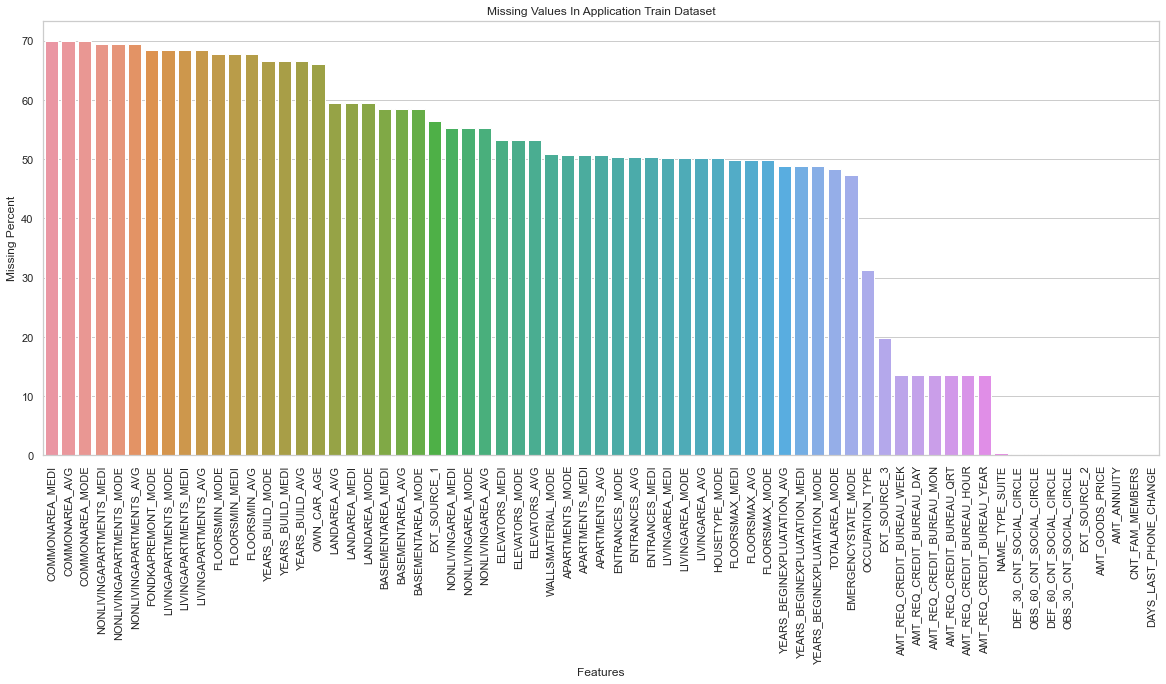

<IPython.core.display.Javascript object>

In [31]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(
    x=application_missing_values_train.index,
    y="% of Total Values",
    data=application_missing_values_train,
)
ax.set(
    xlabel="Features",
    ylabel="Missing Percent",
    title="Missing Values In Application Train Dataset",
)
plt.xticks(rotation=90)
plt.show()

In [32]:
application_missing_values_test = hc.missing_values(df_application_test)
application_missing_values_test.head(5)

,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.70000
COMMONAREA_MEDI,33495,68.70000
COMMONAREA_AVG,33495,68.70000
NONLIVINGAPARTMENTS_MEDI,33347,68.40000
NONLIVINGAPARTMENTS_AVG,33347,68.40000


<IPython.core.display.Javascript object>

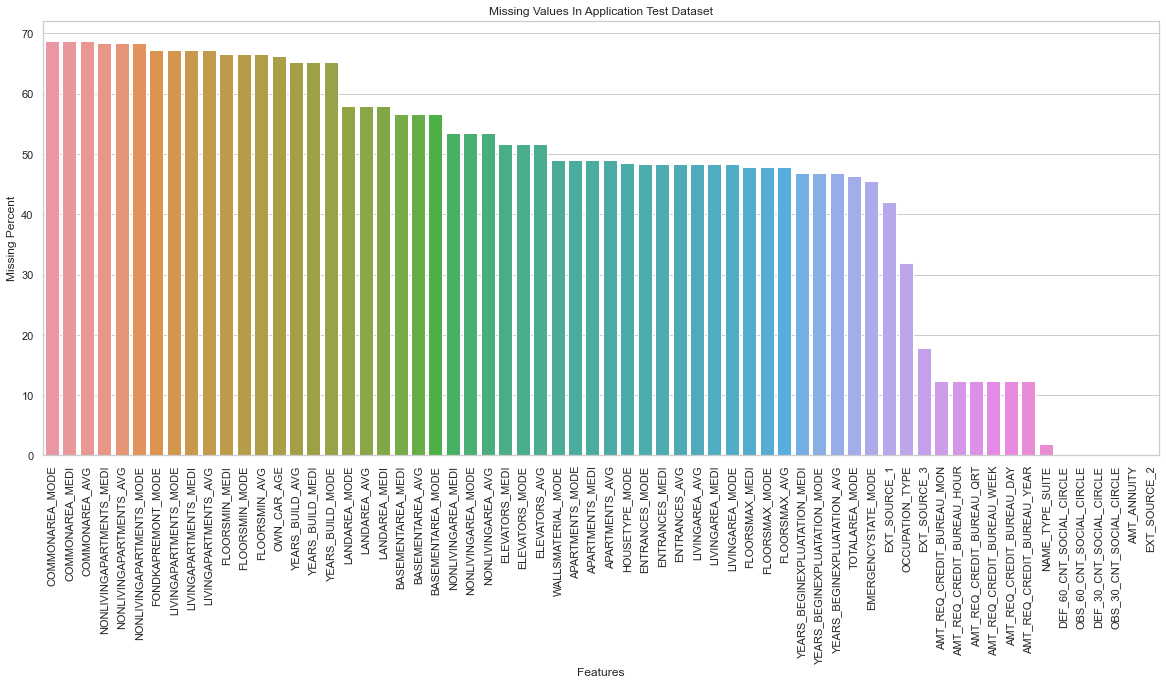

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(
    x=application_missing_values_test.index,
    y="% of Total Values",
    data=application_missing_values_test,
)
ax.set(
    xlabel="Features",
    ylabel="Missing Percent",
    title="Missing Values In Application Test Dataset",
)
plt.xticks(rotation=90)
plt.show()

## Correlation

### Multicolinearity 

Lets see if in application dataset we have features that strongly correlates with each other

In [36]:
corr_matrix_application = (
    df_application_train_drop.drop(columns=["TARGET", "SK_ID_CURR"]).corr().abs()
)
upper_application = corr_matrix_application.where(
    np.triu(np.ones(corr_matrix_application.shape), k=1).astype(np.bool)
)
corr_features_application = [
    column
    for column in upper_application.columns
    if any(upper_application[column] > 0.95)
]

if len(corr_features_application) == 0:
    corr_features_application = 0
print(
    f"Features that has more than 0.95 correlation with other feature: {corr_features_application}"
)

Features that has more than 0.95 correlation with other feature: ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE']


<IPython.core.display.Javascript object>

As we can see there are quite a few features that has very high correlation with other features. It's a good practise to delete these features to keep model simplier and more stable. Although after deleting them I found that my main LGBM model was performing worse, therefore I decided to keep them in.

### Correlation with target

In [37]:
corrs_application = df_application_train_drop.corr()[["TARGET"]].sort_values(
    by="TARGET", ascending=False
)
corrs_application = corrs_application.rename(columns={"TARGET": "target_corr"})
corrs_application = corrs_application.drop(["TARGET", "SK_ID_CURR"])
corrs_application

,target_corr
DAYS_BIRTH,0.07824
REGION_RATING_CLIENT_W_CITY,0.06089
REGION_RATING_CLIENT,0.05890
DAYS_LAST_PHONE_CHANGE,0.05522
DAYS_ID_PUBLISH,0.05146
...,...
FLOORSMAX_AVG,-0.04400
DAYS_EMPLOYED,-0.04493
EXT_SOURCE_1,-0.15532
EXT_SOURCE_2,-0.16047


<IPython.core.display.Javascript object>

In [38]:
def top_correlated_features(
    corrs: pd.DataFrame, threshold: float, top: int, plot=True
) -> pd.DataFrame():
    """
    Takes dataframe, finds most correlated positive and negative features with target.
    If argument plot is set to True then function will plot two bar plots representing top
    positive and negative correlated features values.
    """
    top_positive_corr = corrs[(corrs["target_corr"] > threshold)][:top]
    if len(top_positive_corr) < 10:
        print(
            f"Considering {threshold} threshold there are only {len(top_positive_corr)} positive correlated features"
        )

    top_negative_corr = corrs[(corrs["target_corr"] < -threshold)][-top:]
    if len(top_negative_corr) < 10:
        print(
            f"Considering {threshold} threshold there are only {len(top_negative_corr)} negative correlated features"
        )

    top_corr_features = pd.concat(
        [
            top_positive_corr,
            top_negative_corr,
        ]
    )

    if plot == True:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        if len(top_positive_corr) != 0:
            sns.barplot(
                x=top_positive_corr.index,
                y="target_corr",
                data=top_positive_corr,
                ax=ax[0],
            )
            ax[0].tick_params(axis="x", rotation=90)
            ax[0].set(
                ylabel="Correlation With Target",
                title=f"Top positive correlated features",
            )
        if len(top_negative_corr) != 0:
            sns.barplot(
                x=top_negative_corr.index,
                y="target_corr",
                data=top_negative_corr,
                ax=ax[1],
            )
            ax[1].tick_params(axis="x", rotation=90)
            ax[1].set(
                ylabel="Correlation With Target",
                title=f"Top negative correlated features",
            )
            ax[1].invert_yaxis()
        fig.show()

    return top_corr_features

<IPython.core.display.Javascript object>

c:\users\gelezis\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


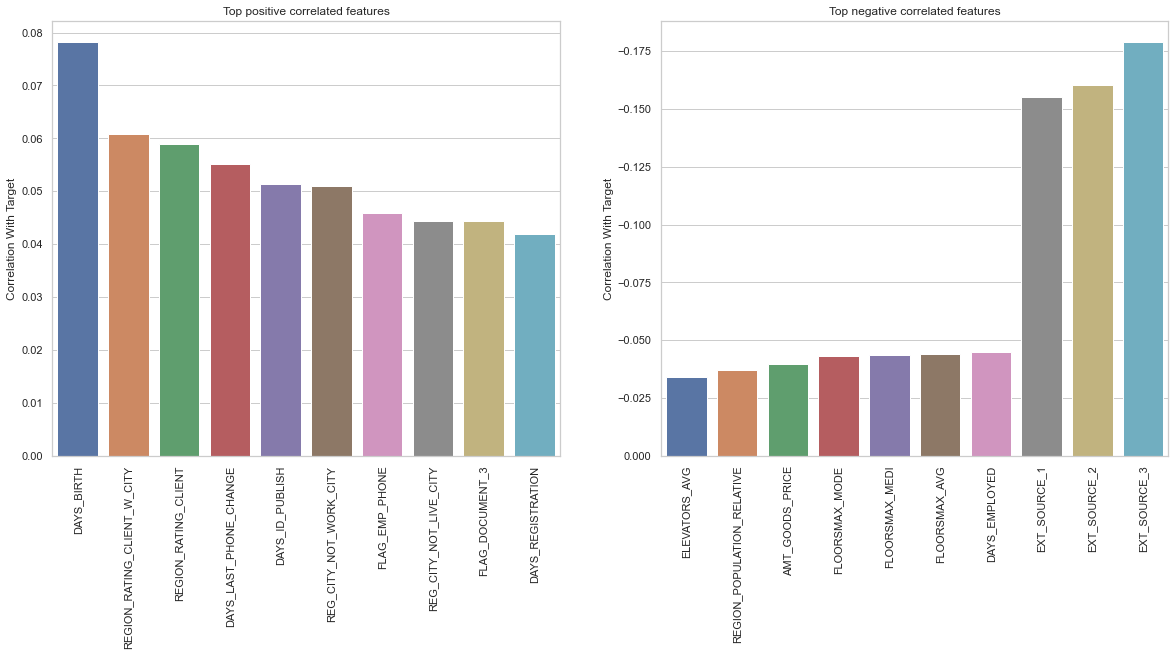

<IPython.core.display.Javascript object>

In [39]:
application_top_corr = top_correlated_features(corrs_application, 0.01, 10)

Lets double check if these most correlated features has missing values and how much:

In [40]:
missing_application_top_corr = hc.missing_values(
    df_application_train_drop[application_top_corr.index]
)
missing_application_top_corr

,Missing Values,% of Total Values
EXT_SOURCE_1,173378,56.40000
ELEVATORS_AVG,163891,53.30000
FLOORSMAX_MODE,153020,49.80000
FLOORSMAX_MEDI,153020,49.80000
FLOORSMAX_AVG,153020,49.80000
EXT_SOURCE_3,60965,19.80000
EXT_SOURCE_2,660,0.20000
AMT_GOODS_PRICE,278,0.10000
DAYS_LAST_PHONE_CHANGE,1,0.00000


<IPython.core.display.Javascript object>

## Impute Missing Values

For value imputation, instead of mean imputation I will use median imputation which is good for avoiding outliers impact. Although I have tried to use stochastic regression imputation as well, although it gave me lower LGBM and Kaggle scores. Most likely it tried to introduce a pattern that was not actually there in the dataset. Additionaly I wanted to try knn imputer, but it was taking forever to compute.Therefore I kept it simple.

In [41]:
missing_train = hc.missing_values(df_application_train_drop).index
missing_test = hc.missing_values(df_application_test_drop).index

<IPython.core.display.Javascript object>

In [42]:
missing_numerical_train = [
    feature
    for feature in df_application_train_drop[missing_train].columns
    if df_application_train_drop[feature].dtype in ["int64", "float64"]
]

missing_numerical_test = [
    feature
    for feature in df_application_test_drop[missing_test].columns
    if df_application_test_drop[feature].dtype in ["int64", "float64"]
]

<IPython.core.display.Javascript object>

In [43]:
missing_numerical_diff = list(
    set(missing_numerical_train) - set(missing_numerical_test)
)
print(
    f"Test data has {len(missing_numerical_diff)} different numerical features that has missing values."
)
missing_numerical = missing_numerical_test + missing_numerical_diff

Test data has 3 different numerical features that has missing values.


<IPython.core.display.Javascript object>

In [44]:
missing_categorical_train = [
    feature
    for feature in df_application_train_drop[missing_train].columns
    if df_application_train_drop[feature].dtype == "object"
]

missing_categorical_test = [
    feature
    for feature in df_application_test_drop[missing_test].columns
    if df_application_test_drop[feature].dtype == "object"
]

<IPython.core.display.Javascript object>

In [45]:
missing_categorical_diff = list(
    set(missing_categorical_train) - set(missing_categorical_test)
)
print(
    f"Test data has {len(missing_categorical_diff)} different categorical features that has missing values."
)
missing_categorical = missing_categorical_train + missing_categorical_diff

Test data has 0 different categorical features that has missing values.


<IPython.core.display.Javascript object>

In [47]:
# Impute categorical features
(df_application_train_drop_imp, df_application_test_drop_imp) = hc.impute_missing_cat(
    df_application_train_drop, df_application_test_drop, missing_categorical
)
# Impute numerical features
(df_application_train_drop_imp, df_application_test_drop_imp) = hc.impute_missing_num(
    df_application_train_drop_imp, df_application_test_drop_imp, missing_numerical
)

missing_train_left = len(
    hc.missing_values(df_application_train_drop_imp)["Missing Values"]
)
missing_test_left = len(
    hc.missing_values(df_application_test_drop_imp)["Missing Values"]
)
print(
    f"Features with missing values on train data: {missing_train_left}\nFeatures with missing values on test data: {missing_test_left}"
)

Features with missing values on train data: 0
Features with missing values on test data: 0


<IPython.core.display.Javascript object>

## Encode Categorical Features

For encoding I will use one hot encoder. As we can see some features has quite many classes, although because we have quite many samples it shouldn't cause curse of dimensionality.

In [48]:
categorical_count_application = df_application_train_drop_imp.select_dtypes(
    "object"
).apply(pd.Series.nunique, axis=0)
categorical_count_application

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
WALLSMATERIAL_MODE             7
HOUSETYPE_MODE                 3
EMERGENCYSTATE_MODE            2
OCCUPATION_TYPE               18
NAME_TYPE_SUITE                7
dtype: int64

<IPython.core.display.Javascript object>

In [49]:
(
    df_application_train_drop_imp_enc,
    df_application_test_drop_imp_enc,
) = hc.encode_categorical(
    df_application_train_drop_imp,
    df_application_test_drop_imp,
    categorical_count_application.index,
)

# Remove special characters from column names ( for LGBM model)
df_application_train_drop_imp_enc = df_application_train_drop_imp_enc.rename(
    columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x)
)
df_application_test_drop_imp_enc = df_application_test_drop_imp_enc.rename(
    columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x)
)
df_application_train_drop_imp_enc.head(5)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied
0,100002,1,0,202500.00000,406597.50000,0.01880,-9461,-637,-3648.00000,-2120,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,0,270000.00000,1293502.50000,0.00354,-16765,-1188,-1186.00000,-291,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,0,67500.00000,135000.00000,0.01003,-19046,-225,-4260.00000,-2531,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
3,100006,0,0,135000.00000,312682.50000,0.00802,-19005,-3039,-9833.00000,-2437,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
4,100007,0,0,121500.00000,513000.00000,0.02866,-19932,-3038,-4311.00000,-3458,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


<IPython.core.display.Javascript object>

## Min Max Scaler

Before training let's scale our data. I will use minmax scaler, although I have considered to use robust scaler, because it is less sensitive to outliers, but because I have decided to investage outliers later with isolation forest algorithm I thought to stick with min max scaler.

In [50]:
df_train_full_scaled, df_test_full_scaled = hc.scale_minmax(
    df_application_train_drop_imp_enc,
    df_application_test_drop_imp_enc,
)

<IPython.core.display.Javascript object>

In [51]:
df_train_full_scaled.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,TARGET,SK_ID_CURR
0,0.00000,0.00151,0.09029,0.25632,0.88884,0.04509,0.85214,0.70543,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1,100002
1,0.00000,0.00209,0.31174,0.04502,0.47711,0.04365,0.95193,0.95957,1.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100003
2,0.00000,0.00036,0.02247,0.13490,0.34853,0.04616,0.82733,0.64833,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0,100004
3,0.00000,0.00093,0.06684,0.10702,0.35085,0.03882,0.60145,0.66139,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0,100006
4,0.00000,0.00082,0.11685,0.39288,0.29859,0.03882,0.82527,0.51952,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0,100007


<IPython.core.display.Javascript object>

# Baseline model

In [52]:
X_train_full = df_train_full_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full = df_test_full_scaled.drop(columns=["SK_ID_CURR"])

y_train_full = df_train_full_scaled["TARGET"].copy()

<IPython.core.display.Javascript object>

In [53]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    stratify=y_train_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

### Logistic Regression

Logistic Regression by default uses Gradient Descent although Stochastic gradient descent is much faster than gradient descent when dealing with large data sets. Therefore I will use SGD Classifier which implements logistic regression with Stochastic Gradient Descent.

In [96]:
log_clsf = SGDClassifier(
    alpha=0.0001,
    penalty="l1",
    loss="log",
    class_weight="balanced",
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

In [97]:
%%time
log_clsf.fit(X_train,y_train)

Wall time: 12.3 s


SGDClassifier(class_weight='balanced', loss='log', penalty='l1', random_state=0)

<IPython.core.display.Javascript object>

In [98]:
%%time
# To make SGDClassifier predict calibrated probabilities we will need to use CalibratedClassifierCV
log_sig_clsf = CalibratedClassifierCV(log_clsf, method="sigmoid")
log_sig_clsf.fit(X_train, y_train)

Wall time: 48.5 s


CalibratedClassifierCV(base_estimator=SGDClassifier(class_weight='balanced',
                                                    loss='log', penalty='l1',
                                                    random_state=0))

<IPython.core.display.Javascript object>

In [99]:
%%time
y_pred_train, y_pred_val = hc.get_binary_predictions(log_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(
    log_sig_clsf, X_train, X_val
)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.6535641117362037
Validation accuracy is 0.6586182787831488
Training precision is 0.1503370065261581
Validation precision is 0.1537431422523651
Training recall is 0.7075528700906344
Validation recall is 0.7168177240684793
Training ROC AUC is 0.7437416052131802
Validation ROC AUC is 0.7501323655912944
Wall time: 1.44 s


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Confusion matrix')

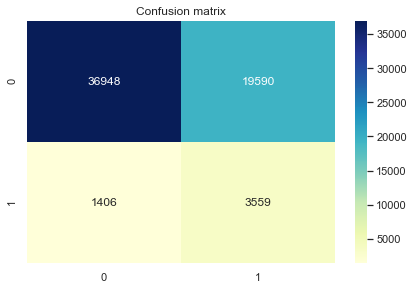

<IPython.core.display.Javascript object>

In [86]:
cnf_matrix = confusion_matrix(y_val, y_pred_val)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix")

We can see that our model predict quite many false positive cases. Unfortunately the cost of a mis-classification is very high. Let’s say, for an applicant A our model labelled as ‘Repaying the loan’. So the organization sanctioned the loan for that applicant. But the applicant for some reason is not able to pay the loan. This type of scenarios is loss to the organization. Hence we should come up with a model which can reduce the mis-classifications as much as possible. Most importantly we should concentrate in increasing recall score (reduce False Negative count).

In [87]:
df_scores = pd.DataFrame()

dict_scores = {
    "Model": ["LogReg"],
    "Notes": ["Baseline All Features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))

df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LogReg,Baseline All Features,0.65356,0.65862,0.15034,0.15374,0.70755,0.71682,0.74374,0.75013


<IPython.core.display.Javascript object>

As we can see our model produce very low precision scores, but it was expected because we already saw confusion matrix which showed very high false positive rate. Hyperparameter class_weight = 'balanced' helped used to weight our predictions depending on the class, but results are not very satisfying. Besides precision problem, our model is not overfitting and seems working fine.

### Random Forest

The Random Forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:
* Random sampling of training data points when building trees
* Random subsets of features considered when splitting nodes

In [100]:
rf_clsf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=7,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

<IPython.core.display.Javascript object>

In [101]:
%%time
rf_clsf.fit(X_train, y_train)

Wall time: 4min 46s


RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=1000,
                       n_jobs=-1, random_state=0)

<IPython.core.display.Javascript object>

In [92]:
%%time
y_pred_train, y_pred_val = hc.get_binary_predictions(rf_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(
    rf_clsf, X_train, X_val
)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.6822583005430718
Validation accuracy is 0.6815439897240785
Training precision is 0.1582439481859211
Validation precision is 0.15531142439530388
Training recall is 0.6797079556898288
Validation recall is 0.6634441087613293
Training ROC AUC is 0.7465539125684806
Validation ROC AUC is 0.7316819847247261
Wall time: 48 s


<IPython.core.display.Javascript object>

In [91]:
dict_scores = {
    "Model": ["RandomForest"],
    "Notes": ["Baseline All Features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LogReg,Baseline All Features,0.65356,0.65862,0.15034,0.15374,0.70755,0.71682,0.74374,0.75013
1,RandomForest,Baseline All Features,0.68226,0.68154,0.15824,0.15531,0.67971,0.66344,0.74655,0.73168


<IPython.core.display.Javascript object>

As we can see random forest performed better on training set then logistic regression, although worse on validation set. Moreover it took much more time to train and get metrics scores.

### LGBM

LGBM is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

In [54]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [55]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 13.3 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [104]:
%%time
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(
    LGBM_clsf, X_train, X_val
)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.7120947286267113
Validation accuracy is 0.7106320016909744
Training precision is 0.17977104512497016
Validation precision is 0.17278661770705833
Training recall is 0.720342396777442
Validation recall is 0.6823766364551863
Training ROC AUC is 0.7942081588470764
Validation ROC AUC is 0.7641543191886523
Wall time: 12.3 s


<IPython.core.display.Javascript object>

In [105]:
dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Baseline All Features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LogReg,Baseline All Features,0.65356,0.65862,0.15034,0.15374,0.70755,0.71682,0.74374,0.75013
1,RandomForest,Baseline All Features,0.68226,0.68154,0.15824,0.15531,0.67971,0.66344,0.74655,0.73168
2,LGBM,Baseline All Features,0.71209,0.71063,0.17977,0.17279,0.72034,0.68238,0.79421,0.76415


<IPython.core.display.Javascript object>

In [56]:
hc.get_importance(LGBM_clsf, X_train_full, 20)

,Feature,Weight
87,EXT_SOURCE_1,233
88,EXT_SOURCE_3,221
100,EXT_SOURCE_2,190
4,DAYS_BIRTH,177
2,AMT_CREDIT,169
99,AMT_ANNUITY,163
103,AMT_GOODS_PRICE,146
5,DAYS_EMPLOYED,118
7,DAYS_ID_PUBLISH,94
102,DAYS_LAST_PHONE_CHANGE,91


<IPython.core.display.Javascript object>

As we can see LGBM clasifier scores was the best and it trains much faster than other models, therefore I will use it as my main model for further research.Seems that EXT_SOURCE feature are most important features, which as we saw is not a coincidence, because they were top corelated with target features.

### Save And Load Scores

In [106]:
df_scores.to_csv("data/application_scores_baseline.csv", index=False)

<IPython.core.display.Javascript object>

In [72]:
df_scores = pd.read_csv("data/application_scores_baseline.csv")
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LogReg,Baseline All Features,0.65356,0.65862,0.15034,0.15374,0.70755,0.71682,0.74374,0.75013
1,RandomForest,Baseline All Features,0.68226,0.68154,0.15824,0.15531,0.67971,0.66344,0.74655,0.73168
2,LGBM,Baseline All Features,0.71209,0.71063,0.17977,0.17279,0.72034,0.68238,0.79421,0.76415


<IPython.core.display.Javascript object>

# Outliers

## Isolation Forest

Isolation forest is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.

Isolation forest works on the principle of the decision tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the maximum and minimum values of the selected feature. This random partitioning of features will produce smaller paths in trees for the anomalous data values and distinguish them from the normal set of the data.

Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1

In [111]:
num_columns = [
    feature
    for feature in df_application_train_drop.drop(
        columns=["SK_ID_CURR", "TARGET"]
    ).columns
    if df_application_train_drop[feature].dtype in ["int64", "float64"]
]

<IPython.core.display.Javascript object>

In [283]:
%%time
result = pd.DataFrame()
for feature in num_columns:    
    stats = hc.isolation_forest_feature(df_application_train_drop_imp, feature)
    result = pd.concat([result, stats])

Wall time: 28min 56s


<IPython.core.display.Javascript object>

In [288]:
outliers = {
    team: grp.drop("feature", axis=1)
    for team, grp in result.sort_values(by="score").groupby("feature")
}

<IPython.core.display.Javascript object>

Because finding outliers for every features seperately took long time to compute we will save outliers dictionary with pickle library in case our kernel will crash or restart.

In [289]:
def save_obj(obj, name: str) -> None:
    ""
    with open(name + ".pkl", "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

In [291]:
save_obj(outliers, "application_outliers")

<IPython.core.display.Javascript object>

In [113]:
def load_obj(name: str) -> None:
    with open(name + ".pkl", "rb") as f:
        return pickle.load(f)

<IPython.core.display.Javascript object>

In [115]:
outliers = load_obj("application_outliers")

<IPython.core.display.Javascript object>

In [290]:
n_outliers = 20
for feature in num_columns:
    hc.print_outliers(outliers, feature, n_outliers)

CNT_CHILDREN
            val    score  outlier     min      max    mean
188264  6.00000 -0.23544       -1 0.00000 19.00000 0.41705
245243  6.00000 -0.23544       -1 0.00000 19.00000 0.41705
155369 19.00000 -0.23544       -1 0.00000 19.00000 0.41705
25669   6.00000 -0.23544       -1 0.00000 19.00000 0.41705
182163  6.00000 -0.23544       -1 0.00000 19.00000 0.41705
46393   6.00000 -0.23544       -1 0.00000 19.00000 0.41705
7204    6.00000 -0.23544       -1 0.00000 19.00000 0.41705
233611  7.00000 -0.23544       -1 0.00000 19.00000 0.41705
116428  7.00000 -0.23544       -1 0.00000 19.00000 0.41705
132585 10.00000 -0.23544       -1 0.00000 19.00000 0.41705
3079    7.00000 -0.23544       -1 0.00000 19.00000 0.41705
160821  6.00000 -0.23544       -1 0.00000 19.00000 0.41705
140914  6.00000 -0.23544       -1 0.00000 19.00000 0.41705
76087   6.00000 -0.23544       -1 0.00000 19.00000 0.41705
171125 12.00000 -0.23544       -1 0.00000 19.00000 0.41705
173205  6.00000 -0.23544       -1 0.00000 1

           val    score  outlier     min     max    mean
85407  0.00070 -0.07784       -1 0.00000 0.85500 0.51450
212383 0.00007 -0.07784       -1 0.00000 0.85500 0.51450
205088 0.00001 -0.07784       -1 0.00000 0.85500 0.51450
101809 0.00047 -0.07784       -1 0.00000 0.85500 0.51450
257077 0.00050 -0.07784       -1 0.00000 0.85500 0.51450
96492  0.00006 -0.07784       -1 0.00000 0.85500 0.51450
204346 0.00021 -0.07784       -1 0.00000 0.85500 0.51450
99084  0.00026 -0.07784       -1 0.00000 0.85500 0.51450
85088  0.00039 -0.07784       -1 0.00000 0.85500 0.51450
88409  0.00057 -0.07784       -1 0.00000 0.85500 0.51450
2604   0.00070 -0.07784       -1 0.00000 0.85500 0.51450
271652 0.00004 -0.07784       -1 0.00000 0.85500 0.51450
208197 0.00047 -0.07784       -1 0.00000 0.85500 0.51450
216005 0.00073 -0.07784       -1 0.00000 0.85500 0.51450
3739   0.00026 -0.07784       -1 0.00000 0.85500 0.51450
204248 0.00005 -0.07784       -1 0.00000 0.85500 0.51450
205531 0.00031 -0.07784       -

<IPython.core.display.Javascript object>

## Outliers investigation

In [116]:
df_application_train_drop_imp[
    (df_application_train_drop_imp["CNT_CHILDREN"] > 10).values
]["CNT_CHILDREN"]

34545     11
80948     12
155369    19
171125    12
176011    14
183878    14
265784    19
267998    14
Name: CNT_CHILDREN, dtype: int64

<IPython.core.display.Javascript object>

In [117]:
days_employed_outliers = (
    df_application_train_drop_imp[
        (df_application_train_drop_imp["DAYS_EMPLOYED"] / 365) > 0
    ]["DAYS_EMPLOYED"]
    / 365
).sort_values(ascending=False)
days_employed_outliers

307507   1000.66575
103344   1000.66575
103422   1000.66575
103398   1000.66575
103386   1000.66575
            ...    
204998   1000.66575
204995   1000.66575
204994   1000.66575
204976   1000.66575
8        1000.66575
Name: DAYS_EMPLOYED, Length: 55374, dtype: float64

<IPython.core.display.Javascript object>

In [299]:
df_application_train_drop_imp[
    (df_application_train_drop_imp["CNT_FAM_MEMBERS"] > 10).values
]["CNT_FAM_MEMBERS"]

34545    13.00000
80948    14.00000
132585   12.00000
155369   20.00000
171125   14.00000
176011   15.00000
183878   16.00000
186820   12.00000
265784   20.00000
267998   16.00000
276768   11.00000
Name: CNT_FAM_MEMBERS, dtype: float64

<IPython.core.display.Javascript object>

In [300]:
df_application_train_drop_imp[
    df_application_train_drop_imp["OBS_30_CNT_SOCIAL_CIRCLE"] > 30
]["OBS_30_CNT_SOCIAL_CIRCLE"]

77497     47.00000
148403   348.00000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

<IPython.core.display.Javascript object>

In [301]:
df_application_train_drop_imp[
    df_application_train_drop_imp["DEF_30_CNT_SOCIAL_CIRCLE"] > 8
]["DEF_30_CNT_SOCIAL_CIRCLE"]

148403   34.00000
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

<IPython.core.display.Javascript object>

In [302]:
df_application_train_drop_imp[
    df_application_train_drop_imp["DEF_60_CNT_SOCIAL_CIRCLE"] > 7
]["DEF_60_CNT_SOCIAL_CIRCLE"]

148403   24.00000
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

<IPython.core.display.Javascript object>

In [120]:
df_application_train_drop_imp[df_application_train_drop_imp["FLAG_DOCUMENT_10"] == 1][
    "FLAG_DOCUMENT_10"
]

28723     1
60622     1
107774    1
155351    1
169324    1
181877    1
266339    1
Name: FLAG_DOCUMENT_10, dtype: int64

<IPython.core.display.Javascript object>

In [307]:
df_application_train_drop_imp[
    df_application_train_drop_imp["AMT_REQ_CREDIT_BUREAU_QRT"] > 10
]["AMT_REQ_CREDIT_BUREAU_QRT"]

239474   261.00000
253541    19.00000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

<IPython.core.display.Javascript object>

In [64]:
income_outliers = df_application_train_drop_imp[
    df_application_train_drop_imp["AMT_INCOME_TOTAL"] > 100000000
]["AMT_INCOME_TOTAL"]
income_outliers

12840   117000000.00000
Name: AMT_INCOME_TOTAL, dtype: float64

<IPython.core.display.Javascript object>

Let's quickly review the results that caught my eye:
*  CNT_CHILDREN: Someone has 19 children which deviates a lot from the average.
*  DAYS_EMPLOYED: There are people who had been working for  more than 900 years.
*  CNT_FAM_MEMBERS: Interestingly we can see that some people has significantly more family members than average.
*  OBS_30_CNT_SOCIAL_CIRCLE: Only two samples has value bigger than 30.
*  DEF_30_CNT_SOCIAL_CIRCLE: There is only one sample that has bigger value than 8 and it is 34 which is significant.
*  DEF_60_CNT_SOCIAL_CIRCLE: There is only one sample that has bigger value than 7 and it is 24 which is significant.
*  FLAG_DOCUMENT_10: Only 7 people provided document 10. We can remove this feature.
*  AMT_REQ_CREDIT_BUREAU_QRT: There are two significantly bigger values than 10.
*  AMT_INCOME_TOTAL: Someone suspiciously have very high income which is more than 100 million. 

Let's try to clean up data with these notices in mind.

## Outliers Fixing

In [53]:
df_application_train_drop_imp_enc_iso = df_application_train_drop_imp_enc.copy()
df_application_test_drop_imp_enc_iso = df_application_test_drop_imp_enc.copy()

<IPython.core.display.Javascript object>

In [54]:
def process_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Clipps outliers"""
    df["CNT_CHILDREN"] = df["CNT_CHILDREN"].clip(0, 10)
    df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].clip(-17912, 25550) 
    
    df = df.drop(columns=["FLAG_DOCUMENT_10"])
    df = df.drop(index=[77497, 148403, 239474, 253541])
    df = df.drop(index=income_outliers.index)
    df = df.reset_index(drop=True)
    return df

<IPython.core.display.Javascript object>

In [65]:
df_application_train_drop_imp_enc_iso = process_outliers(
    df_application_train_drop_imp_enc_iso
)
df_application_test_drop_imp_enc_iso = df_application_test_drop_imp_enc_iso.drop(columns=["FLAG_DOCUMENT_10"])


<IPython.core.display.Javascript object>

In [66]:
# Scale new data
df_train_full_iso_scaled, df_test_full_iso_scaled = hc.scale_minmax(
    df_application_train_drop_imp_enc_iso,
    df_application_test_drop_imp_enc_iso,
)

<IPython.core.display.Javascript object>

In [67]:
X_train_full_iso = df_train_full_iso_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full_iso = df_test_full_iso_scaled.drop(columns=["SK_ID_CURR"])

y_train_full_iso = df_train_full_iso_scaled["TARGET"].copy()

<IPython.core.display.Javascript object>

In [68]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_iso,
    y_train_full_iso,
    stratify=y_train_full_iso,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

In [69]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [70]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 18.2 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [71]:
%%time
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(
    LGBM_clsf, X_train, X_val
)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.7124030503569048
Validation accuracy is 0.7037006926604013
Training precision is 0.180286468149265
Validation precision is 0.1660116888351471
Training recall is 0.722580320273945
Validation recall is 0.6636455186304129
Training ROC AUC is 0.7950352473242679
Validation ROC AUC is 0.7586514875935857
Wall time: 6.16 s


<IPython.core.display.Javascript object>

In [73]:
dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Isolation Forest Outliers Manually"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LogReg,Baseline All Features,0.65356,0.65862,0.15034,0.15374,0.70755,0.71682,0.74374,0.75013
1,RandomForest,Baseline All Features,0.68226,0.68154,0.15824,0.15531,0.67971,0.66344,0.74655,0.73168
2,LGBM,Baseline All Features,0.71209,0.71063,0.17977,0.17279,0.72034,0.68238,0.79421,0.76415
3,LGBM,Isolation Forest Outliers Manually,0.71240,0.70370,0.18029,0.16601,0.72258,0.66365,0.79504,0.75865


<IPython.core.display.Javascript object>

After deleting and clipping outliers we managed to increase scores on the training set, but we didn't get any luck on validation set. Therefore I decided to leave these outliers in.

#  Feature Engineering

In [57]:
df_train_full_feat_eng = df_application_train_drop_imp_enc.drop(
    columns=["TARGET", "SK_ID_CURR"]
)
df_test_full_feat_eng = df_application_test_drop_imp_enc.drop(columns=["SK_ID_CURR"])
y_train_full_feat_eng = df_application_train_drop_imp_enc["TARGET"]

<IPython.core.display.Javascript object>

In [58]:
def payment_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates two features:
    * ANNUITY_CREDIT_RATIO which is  ratio of amount Annuity(amount to pay back every month)
    and amount credit (amount given by home credit).
    * CREDIT_ANNUITY_RATIO which is inverse of amount annuity and amount credit ratio.
    """
    data["ANNUITY_CREDIT_RATIO"] = data["AMT_ANNUITY"] / data["AMT_CREDIT"]
    data["CREDIT_ANNUITY_RATIO"] = data["AMT_CREDIT"] / data["AMT_ANNUITY"]

    return data

<IPython.core.display.Javascript object>

In [59]:
def goods_price_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates three features:
    * GOODS_PRICE_AMT_ANNUITY_RATIO which is  ratio of AMT_GOODS_PRICE(
    For consumer loans it is the price of the goods for which the loan is given) and AMT_ANNUITY
    (amount to pay back every month)
    * GOODS_PRICE_AMT_INCOME_TOTAL_RATIO which is  ratio of AMT_GOODS_PRICE and AMT_INCOME_TOTAL
    * GOODS_PRICE_AMT_CREDIT_RATIO which is  ratio of AMT_GOODS_PRICE and AMT_CREDIT
    """
    data["GOODS_PRICE_AMT_ANNUITY_RATIO"] = (
        data["AMT_GOODS_PRICE"] / data["AMT_ANNUITY"]
    )

    data["GOODS_PRICE_AMT_INCOME_TOTAL_RATIO"] = (
        data["AMT_GOODS_PRICE"] / data["AMT_INCOME_TOTAL"]
    )

    data["GOODS_PRICE_AMT_CREDIT_RATIO"] = data["AMT_GOODS_PRICE"] / data["AMT_CREDIT"]

    return data

<IPython.core.display.Javascript object>

In [60]:
def annuity_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates two features:
    * ANNUITY_DAYS_EMPLOYED_RATIO which is ratio of AMT_ANNUITY and DAYS_EMPLOYED
    * ANNUITY_DAYS_BIRTH_RATIO which is ratio of AMT_ANNUITY and DAYS_BIRTH
    """
    data["ANNUITY_DAYS_EMPLOYED_RATIO"] = data["AMT_ANNUITY"] / data["DAYS_EMPLOYED"]
    data["ANNUITY_DAYS_BIRTH_RATIO"] = data["AMT_ANNUITY"] / data["DAYS_BIRTH"]

    return data

<IPython.core.display.Javascript object>

In [61]:
def ext_features(data: pd.DataFrame) -> pd.DataFrame:
    """Engineers EXT_SOURCE mean,meadian,max and min features"""

    data_eng = data[["SK_ID_CURR"]].copy()

    data_eng["EXT_SOURCE_MEAN"] = [
        np.nanmean([ele1, ele2, ele3])
        for ele1, ele2, ele3 in zip(
            data["EXT_SOURCE_1"], data["EXT_SOURCE_2"], data["EXT_SOURCE_3"]
        )
    ]

    data_eng["EXT_SOURCE_MEDIAN"] = [
        np.nanmedian([ele1, ele2, ele3])
        for ele1, ele2, ele3 in zip(
            data["EXT_SOURCE_1"], data["EXT_SOURCE_2"], data["EXT_SOURCE_3"]
        )
    ]

    data_eng["EXT_SOURCE_MAX"] = [
        np.nanmax([ele1, ele2, ele3])
        for ele1, ele2, ele3 in zip(
            data["EXT_SOURCE_1"], data["EXT_SOURCE_2"], data["EXT_SOURCE_3"]
        )
    ]
    data_eng["EXT_SOURCE_MIN"] = [
        np.nanmin([ele1, ele2, ele3])
        for ele1, ele2, ele3 in zip(
            data["EXT_SOURCE_1"], data["EXT_SOURCE_2"], data["EXT_SOURCE_3"]
        )
    ]
    return data_eng

<IPython.core.display.Javascript object>

In [62]:
# This feature was inspired by the winner’s solution writeup
# https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
def neighbors_ext_feature(
    df_train: pd.DataFrame, df_test: pd.DataFrame
) -> pd.DataFrame:
    """
    Takes EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_ANNUITY_RATIO features
    and generates 500 Nearest Neighbors which are used to generate target means.
    """

    train_data_for_neighbors = df_train[
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_ANNUITY_RATIO"]
    ]
    train_data_for_neighbors_imp = train_data_for_neighbors.fillna(0)
    train_target = df_application_train_drop_imp_enc["TARGET"]

    test_data_for_neighbors = df_test[
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_ANNUITY_RATIO"]
    ]
    test_data_for_neighbors_imp = test_data_for_neighbors.fillna(0)

    knn = KNeighborsClassifier(500, n_jobs=-1)
    knn.fit(train_data_for_neighbors, train_target)
    train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
    test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

    df_train["TARGET_NEIGHBORS_500_MEAN"] = [
        df_application_train_drop_imp_enc["TARGET"].iloc[ele].mean()
        for ele in train_500_neighbors
    ]
    df_test["TARGET_NEIGHBORS_500_MEAN"] = [
        df_application_train_drop_imp_enc["TARGET"].iloc[ele].mean()
        for ele in test_500_neighbors
    ]
    return df_train, df_test

<IPython.core.display.Javascript object>

In [63]:
# Let's aggegrate EXT_SOURCE features
ext_features_agg_train = ext_features(df_application_train_drop)
ext_features_agg_test = ext_features(df_application_test_drop)

ext_features_agg_train, ext_features_agg_test = hc.impute_missing_num(
    ext_features_agg_train, ext_features_agg_test, ext_features_agg_test.columns
)

c:\users\gelezis\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
c:\users\gelezis\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
c:\users\gelezis\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: All-NaN axis encountered
c:\users\gelezis\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: All-NaN axis encountered


<IPython.core.display.Javascript object>

In [64]:
# Merge aggregated ext_source features with main dataframe
df_train_full_feat_eng["SK_ID_CURR"] = df_application_train_drop_imp_enc["SK_ID_CURR"]
df_test_full_feat_eng["SK_ID_CURR"] = df_application_test_drop_imp_enc["SK_ID_CURR"]

df_train_full_feat_eng = df_train_full_feat_eng.merge(
    ext_features_agg_train, how="left", on="SK_ID_CURR"
)
df_test_full_feat_eng = df_test_full_feat_eng.merge(
    ext_features_agg_test, how="left", on="SK_ID_CURR"
)

df_train_full_feat_eng = df_train_full_feat_eng.drop(columns=["SK_ID_CURR"])
df_test_full_feat_eng = df_test_full_feat_eng.drop(columns=["SK_ID_CURR"])

<IPython.core.display.Javascript object>

In [65]:
%%time
# Engineer additional features
df_train_full_feat_eng = payment_features(df_train_full_feat_eng)
df_test_full_feat_eng = payment_features(df_test_full_feat_eng)

df_train_full_feat_eng, df_test_full_feat_eng = neighbors_ext_feature(
    df_train_full_feat_eng, df_test_full_feat_eng
)

df_train_full_feat_eng = goods_price_features(df_train_full_feat_eng)
df_test_full_feat_eng = goods_price_features(df_test_full_feat_eng)

df_train_full_feat_eng = annuity_features(df_train_full_feat_eng)
df_test_full_feat_eng = annuity_features(df_test_full_feat_eng)

Wall time: 3min 29s


<IPython.core.display.Javascript object>

Worth mentioning as we saw some combined features had division which created infinite values. Those values occuried because some dividing values were 0. I thought to add small number to 0, but I found that imputing these infit values with median, gave slightly better AUC score.

In [66]:
# Fill infinite values with median value
df_train_full_feat_eng = df_train_full_feat_eng.replace([np.inf, -np.inf], np.nan)
df_test_full_feat_eng = df_test_full_feat_eng.replace([np.inf, -np.inf], np.nan)

df_train_full_feat_eng, df_test_full_feat_eng = hc.impute_missing_num(
    df_train_full_feat_eng, df_test_full_feat_eng, df_test_full_feat_eng.columns
)

<IPython.core.display.Javascript object>

In [67]:
df_train_full_feat_eng["TARGET"] = df_application_train_drop_imp_enc["TARGET"]
df_train_full_feat_eng["SK_ID_CURR"] = df_application_train_drop_imp_enc["SK_ID_CURR"]

df_test_full_feat_eng["SK_ID_CURR"] = df_application_test_drop_imp_enc["SK_ID_CURR"]

<IPython.core.display.Javascript object>

In [68]:
# Scale
df_train_full_feat_eng, df_test_full_feat_eng = hc.scale_minmax(
    df_train_full_feat_eng, df_test_full_feat_eng
)

<IPython.core.display.Javascript object>

In [69]:
X_train_full_feat_eng = df_train_full_feat_eng.drop(
    columns=["TARGET", "SK_ID_CURR"]
)
X_test_full_feat_eng = df_test_full_feat_eng.drop(columns=["SK_ID_CURR"])

<IPython.core.display.Javascript object>

In [70]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_feat_eng,
    y_train_full_feat_eng,
    stratify=y_train_full_feat_eng,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

In [72]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [73]:
%%time
LGBM_clsf.fit(X_train,y_train)

Wall time: 12.7 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [125]:
%%time
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(
    LGBM_clsf, X_train, X_val
)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.7141718968488829
Validation accuracy is 0.7100954424987399
Training precision is 0.18527944111776448
Validation precision is 0.1770022596033141
Training recall is 0.7478348439073514
Validation recall is 0.7099697885196374
Training ROC AUC is 0.808757992186172
Validation ROC AUC is 0.7791562231029139
Wall time: 6.78 s


<IPython.core.display.Javascript object>

In [126]:
dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Feature Engineering"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LogReg,Baseline All Features,0.65356,0.65862,0.15034,0.15374,0.70755,0.71682,0.74374,0.75013
1,RandomForest,Baseline All Features,0.68226,0.68154,0.15824,0.15531,0.67971,0.66344,0.74655,0.73168
2,LGBM,Baseline All Features,0.71209,0.71063,0.17977,0.17279,0.72034,0.68238,0.79421,0.76415
3,LGBM,Isolation Forest Outliers Manually,0.71240,0.70370,0.18029,0.16601,0.72258,0.66365,0.79504,0.75865
4,LGBM,Feature Engineering,0.71417,0.71010,0.18528,0.17700,0.74783,0.70997,0.80876,0.77916


<IPython.core.display.Javascript object>

In [75]:
hc.get_importance(LGBM_clsf, X_train, 20)

,Feature,Weight
234,TARGET_NEIGHBORS_500_MEAN,210
4,DAYS_BIRTH,135
87,EXT_SOURCE_1,112
7,DAYS_ID_PUBLISH,103
88,EXT_SOURCE_3,102
238,ANNUITY_DAYS_EMPLOYED_RATIO,90
5,DAYS_EMPLOYED,88
236,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,82
231,EXT_SOURCE_MIN,80
100,EXT_SOURCE_2,78


<IPython.core.display.Javascript object>

Unfortunately this is only a small fraction of features that I have tried to engineer. Seems that TARGET_NEIGHBORS_500_MEAN feature has most effect on LGBM model. I have tried few more combinations: 

* ANNUITY_LENGTH = AMT_CREDIT / AMT_ANNUITY
* ANNUITY_INCOME_RATIO = AMT_ANNUITY / AMT_INCOME_TOTAL
* WORKING_LIFE_RATIO = DAYS_EMPLOYED / DAYS_BIRTH
* INCOME_PER_PERSON = AMT_INCOME_TOTAL / CNT_CHILDREN
* DAYS_EMPLOYED_RATIO = DAYS_EMPLOYED/ DAYS_BIRTH
* DAYS_REG_RATIO = DAYS_REGISTRATION / DAYS_BIRTH
* LOAN_INCOME_RATIO = AMT_CREDIT / AMT_INCOME_TOTAL
* TOTAL_DOCS_SUBMITTED = SUM(FLAG_DOCUMENT)
* AGE = int(DAYS_BIRTH / -365)

But I didn't get any luck, all these additional features lowered local and kaggle's score.

Let's now go to next dataframes, merge them out, see what additional features we can add and how we can improve our score even more!

# Save Final Processed DataFrames

In [129]:
df_scores.to_csv("data/application_final_scores.csv", index=False)

<IPython.core.display.Javascript object>

In [73]:
df_train_full_feat_eng.to_csv("data/application_train_proc.csv", index=False)

<IPython.core.display.Javascript object>

In [74]:
df_test_full_feat_eng.to_csv("data/application_test_proc.csv", index=False)

<IPython.core.display.Javascript object>

In [75]:
pd.read_csv("data/application_train_proc.csv")

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,TARGET,SK_ID_CURR
0,0.00000,0.00151,0.09029,0.25632,0.88884,0.04509,0.85214,0.70543,1.00000,1.00000,...,0.31105,0.19041,0.54468,0.08367,0.02041,0.10717,0.99838,0.88820,1,100002
1,0.00000,0.00209,0.31174,0.04502,0.47711,0.04365,0.95193,0.95957,1.00000,1.00000,...,0.07648,0.56183,0.08511,0.21774,0.04932,0.10870,0.99874,0.90937,0,100003
2,0.00000,0.00036,0.02247,0.13490,0.34853,0.04616,0.82733,0.64833,1.00000,1.00000,...,0.23499,0.25688,0.05532,0.12821,0.02356,0.12821,0.99874,0.98744,0,100004
3,0.00000,0.00093,0.06684,0.10702,0.35085,0.03882,0.60145,0.66139,1.00000,1.00000,...,0.55299,0.07905,0.06809,0.05132,0.02592,0.12049,0.99957,0.93432,0,100006
4,0.00000,0.00082,0.11685,0.39288,0.29859,0.03882,0.82527,0.51952,1.00000,1.00000,...,0.18279,0.32191,0.15319,0.15483,0.04978,0.12821,0.99968,0.95478,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.00000,0.00113,0.05236,0.44686,0.89639,0.04613,0.65726,0.72461,1.00000,1.00000,...,0.64680,0.05481,0.16596,0.03716,0.01681,0.11027,0.99516,0.87307,0,456251
307507,0.00000,0.00040,0.05607,0.34443,0.25107,1.00000,0.82215,0.43171,1.00000,0.00000,...,0.19625,0.30309,0.19574,0.11857,0.03683,0.10278,0.99998,0.97762,0,456252
307508,0.00000,0.00109,0.15797,0.06525,0.57852,0.02608,0.72694,0.28442,1.00000,1.00000,...,0.19423,0.30581,0.15745,0.12446,0.04508,0.10717,0.99982,0.91492,0,456253
307509,0.00000,0.00124,0.08118,0.06955,0.74791,0.03426,0.89616,0.87064,1.00000,1.00000,...,0.26749,0.22528,0.22979,0.09600,0.02200,0.10717,0.99980,0.92873,1,456254


<IPython.core.display.Javascript object>